In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#project_root = Path().resolve().parent

# pastas de dados
dados_dir = Path("/content/drive/MyDrive/Paula/raw")

arquivos_poluicao = [
    dados_dir / "Poluicao" / "2019-campinas.csv",
    dados_dir / "Poluicao" / "2020-campinas.csv",
    dados_dir / "Poluicao" / "2021-campinas.csv",
    dados_dir / "Poluicao" / "2022-campinas.csv",
    dados_dir / "Poluicao" / "2023-campinas.csv",
]

arquivos_vento = [
    dados_dir / "Vento" / "v2019.csv",
    dados_dir / "Vento" / "v2020.csv",
    dados_dir / "Vento" / "v2021.csv",
    dados_dir / "Vento" / "v2022.csv",
    dados_dir / "Vento" / "v2023.csv",
]

lista_dfs_combinados = []

# Loop para processar os pares de arquivos (poluição + vento)
for arq_pol, arq_vento in zip(arquivos_poluicao, arquivos_vento):

    # --- Processamento do DataFrame de Poluição ---
    df_pol = pd.read_csv(arq_pol, skiprows=7, sep=';', encoding='latin-1', header=None, dtype=str)
    df_pol.rename(columns={0: 'Data', 1: 'Hora', 2: 'pm25', 3: 'temp', 4: 'umidade'}, inplace=True)
    df_pol = df_pol[['Data', 'Hora', 'pm25', 'temp', 'umidade']]
    df_pol.dropna(subset=['Data', 'Hora'], inplace=True)

    mask_hora_24_pol = df_pol['Hora'].str.startswith('24', na=False)
    if mask_hora_24_pol.any():
        datas_corrigidas = pd.to_datetime(df_pol.loc[mask_hora_24_pol, 'Data'], format='%d/%m/%Y') + pd.Timedelta(days=1)
        df_pol.loc[mask_hora_24_pol, 'Data'] = datas_corrigidas.dt.strftime('%d/%m/%Y')
        df_pol.loc[mask_hora_24_pol, 'Hora'] = '00:00'

    df_pol['timestamp'] = pd.to_datetime(df_pol['Data'] + ' ' + df_pol['Hora'], format='%d/%m/%Y %H:%M', errors='coerce')
    df_pol.dropna(subset=['timestamp'], inplace=True)
    df_pol.set_index('timestamp', inplace=True)
    df_pol.drop(['Data', 'Hora'], axis=1, inplace=True)

    # --- Processamento do DataFrame de Vento ---
    df_vento = pd.read_csv(arq_vento, skiprows=7, sep=';', encoding='latin-1', header=None, dtype=str)
    df_vento.rename(columns={0: 'Data', 1: 'Hora', 2: 'vento_dir', 3: 'vento_vel'}, inplace=True)
    df_vento = df_vento[['Data', 'Hora', 'vento_dir', 'vento_vel']]
    df_vento.dropna(subset=['Data', 'Hora'], inplace=True)

    mask_hora_24_vento = df_vento['Hora'].str.startswith('24', na=False)
    if mask_hora_24_vento.any():
        datas_corrigidas = pd.to_datetime(df_vento.loc[mask_hora_24_vento, 'Data'], format='%d/%m/%Y') + pd.Timedelta(days=1)
        df_vento.loc[mask_hora_24_vento, 'Data'] = datas_corrigidas.dt.strftime('%d/%m/%Y')
        df_vento.loc[mask_hora_24_vento, 'Hora'] = '00:00'

    df_vento['timestamp'] = pd.to_datetime(df_vento['Data'] + ' ' + df_vento['Hora'], format='%d/%m/%Y %H:%M', errors='coerce')
    df_vento.dropna(subset=['timestamp'], inplace=True)
    df_vento.set_index('timestamp', inplace=True)
    df_vento.drop(['Data', 'Hora'], axis=1, inplace=True)

    # --- União (Join) dos DataFrames ---
    df_combinado = df_pol.join(df_vento, how='outer')
    lista_dfs_combinados.append(df_combinado)

# Concatena a lista de DataFrames já combinados anualmente
df = pd.concat(lista_dfs_combinados)

colunas_numericas = ['pm25', 'temp', 'umidade', 'vento_dir', 'vento_vel']
for col in colunas_numericas:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')

# Replace 0 values with NaN in the specified columns
cols_to_replace_zero_with_nan = ['pm25'] # Add other columns here if needed
for col in cols_to_replace_zero_with_nan:
    df[col] = df[col].replace(0, np.nan)


df.sort_index(inplace=True)
df.index = df.index - pd.Timedelta(hours=1)
df = df.asfreq('H')

# Exibição dos resultados
display(df.head())
print("\nVerificando valores nulos após a união e substituição de zeros:")
print(df.isnull().sum())

/tmp/ipython-input-3931674995.py:85: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')


,pm25,temp,umidade,vento_dir,vento_vel
timestamp,,,,,
2019-01-01 00:00:00,26.0,23.5,70.0,137.0,4.6
2019-01-01 01:00:00,31.0,22.9,73.0,128.0,3.5
2019-01-01 02:00:00,18.0,22.6,75.0,174.0,1.5
2019-01-01 03:00:00,26.0,22.0,79.0,155.0,1.8
2019-01-01 04:00:00,29.0,21.7,81.0,163.0,1.8



Verificando valores nulos após a união e substituição de zeros:
pm25         7434
temp         3492
umidade      3489
vento_dir    3524
vento_vel    3524
dtype: int64


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math

def train_transformer_generative(
    df,
    feature_cols=['pm25', 'temp', 'umidade', 'vento_dir', 'vento_vel'],
    enc_len=240,
    batch_size=256,
    epochs=20,
    lr=1e-5,
    d_model=256,
    nhead=8,
    num_layers=16,
    device=None,
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # Prepara dados (simples normalização por coluna)
    # NÃO removemos NaNs aqui, o Dataset cuidará disso.
    ds = df[feature_cols].copy()
    means = ds.mean()
    stds = ds.std().replace(0,1.0)
    X = ((ds - means) / stds).to_numpy(dtype=np.float32)

    # Dataset ajustado para pular janelas com NaNs
    class CompleteSeqDataset(Dataset):
        def __init__(self, arr, enc_len):
            self.arr = arr
            self.enc_len = enc_len

            # Pré-computa índices de início válidos
            # Um índice é válido se a janela [i : i + enc_len + 1] inteira não contiver NaNs
            self.valid_indices = []
            n_features = arr.shape[1]
            for i in range(len(arr) - enc_len): # -1 já está implícito no slice
                window = self.arr[i : i + enc_len + 1] # Inclui src e tgt
                # Se não houver nenhum NaN na janela, o índice é válido
                if not np.isnan(window).any():
                    self.valid_indices.append(i)

        def __len__(self):
            return len(self.valid_indices)

        def __getitem__(self, idx):
            i = self.valid_indices[idx]
            src = self.arr[i: i + self.enc_len]      # (enc_len, D)
            tgt = self.arr[i + self.enc_len]        # (D,)
            return torch.from_numpy(src), torch.from_numpy(tgt)

    dataset = CompleteSeqDataset(X, enc_len)

    # Se não houver dados válidos, pare
    if len(dataset) == 0:
        print("Não foram encontradas janelas de dados completas para treinamento.")
        return None, None

    split = int(len(dataset)*0.8)
    train_ds = torch.utils.data.Subset(dataset, range(0, split))
    val_ds = torch.utils.data.Subset(dataset, range(split, len(dataset)))

    # Garante que temos dados de treino e validação
    if len(train_ds) == 0 or len(val_ds) == 0:
        print(f"Não há dados suficientes para divisão treino/val. Total de amostras válidas: {len(dataset)}")
        # Tenta usar tudo para treino se a validação for o problema
        if len(train_ds) == 0 and len(val_ds) > 0:
            train_ds = val_ds
        elif len(train_ds) > 0 and len(val_ds) == 0:
            val_ds = train_ds
        else:
            return None, None # Ainda sem dados

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # Model: simple encoder -> take last token -> MLP -> predict next multivariate step
    class PosEnc(nn.Module):
        def __init__(self, d_model, max_len=1000):
            super().__init__()
            pe = torch.zeros(max_len, d_model)
            pos = torch.arange(0, max_len).unsqueeze(1).float()
            div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(pos * div)
            pe[:, 1::2] = torch.cos(pos * div)
            self.register_buffer('pe', pe.unsqueeze(0))
        def forward(self, x):
            return x + self.pe[:, :x.size(1), :]

    class EncoderNextStep(nn.Module):
        def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward=256, dropout=0.1):
            super().__init__()
            self.input_fc = nn.Linear(input_dim, d_model)
            self.pos = PosEnc(d_model, max_len=enc_len+10)
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
            self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.ReLU(), nn.Linear(d_model//2, input_dim))
        def forward(self, src):
            # src: (B, enc_len, D)
            x = self.input_fc(src) * math.sqrt(d_model)
            x = self.pos(x)
            x = self.encoder(x)      # (B, enc_len, d_model)
            last = x[:, -1, :]       # (B, d_model)
            return self.head(last)   # (B, D)

    model = EncoderNextStep(len(feature_cols), d_model, nhead, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float('inf')
    best_state = model.state_dict() # Salva o estado inicial

    for ep in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for src, tgt in train_loader:
            src = src.to(device)
            tgt = tgt.to(device)
            pred = model(src)
            loss = loss_fn(pred, tgt)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * src.size(0)
        train_loss /= len(train_ds)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for src, tgt in val_loader:
                src = src.to(device); tgt = tgt.to(device)
                pred = model(src)
                val_loss += loss_fn(pred, tgt).item() * src.size(0)
        val_loss /= len(val_ds)

        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
        print(f"[Gen] Epoch {ep}/{epochs} train_loss={train_loss:.6f} val_loss={val_loss:.6f}")

    model.load_state_dict(best_state)
    model.eval()
    meta = {'means': means, 'stds': stds, 'feature_cols': feature_cols, 'enc_len': enc_len}
    return model, meta

def generate_with_model(model, meta, seed_history, steps=24, temperature=1.0, device=None):
    """
    Gera steps multivariados a partir de seed_history (DataFrame or ndarray) de tamanho >= enc_len.
    temperature: escalona ruído aditivo no espaço normalizado (maior -> mais diverso).
    Retorna DataFrame (steps x features) em escala original.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    enc_len = meta['enc_len']
    cols = list(meta['feature_cols'])

    # prepara seed
    if hasattr(seed_history, 'values'):
        arr = seed_history[cols].iloc[-enc_len:].values.astype(np.float32)
    else:
        arr = seed_history[-enc_len:].astype(np.float32)

    # Verifica se o seed tem NaNs
    if np.isnan(arr).any():
        raise ValueError("O 'seed_history' não pode conter NaNs para geração.")

    arr = (arr - meta['means'].values) / meta['stds'].values
    seq = torch.from_numpy(arr).unsqueeze(0).to(device)  # (1, enc_len, D)
    generated = []

    with torch.no_grad():
        for i in range(steps):
            pred = model(seq)                          # (1, D) normalized
            # adicionar ruído gaussiano no espaço normalizado para diversidade
            noise = torch.randn_like(pred) * (0.01 * temperature)
            pred_noisy = pred + noise
            generated.append(pred_noisy.cpu().numpy().squeeze(0))
            # roll seq: append pred_noisy, drop first
            pred_exp = pred_noisy.unsqueeze(1)         # (1,1,D)
            seq = torch.cat([seq[:,1:,:], pred_exp], dim=1)

    gen = np.vstack(generated)  # (steps, D)
    # re-escalar para original
    gen = gen * meta['stds'].values + meta['means'].values
    return pd.DataFrame(gen, columns=cols)


# --- NOVA FUNÇÃO PARA GAP-FILLING (IMPUTAÇÃO) ---

def fill_gaps_with_model(model, meta, df_with_gaps, device=None):
    """
    Preenche lacunas (NaNs) em um DataFrame usando o modelo treinado.

    Funciona de forma autorregressiva:
    1. Normaliza os dados.
    2. Itera pelos timesteps.
    3. Se um timestep 'i' tem NaNs:
        a. Pega o histórico [i-enc_len, ..., i-1].
        b. Se o histórico estiver limpo (sem NaNs), prevê o passo 'i'.
        c. Usa a previsão para preencher os valores NaN no passo 'i'.
        d. Se o histórico tiver NaNs, pula o passo (não pode preencher).
    4. Desnormaliza e retorna o DataFrame preenchido.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()
    enc_len = meta['enc_len']
    cols = list(meta['feature_cols'])

    # Trabalha em uma cópia
    df_filled = df_with_gaps.copy()

    # Extrai e normaliza os dados relevantes
    data = df_filled[cols]
    means = meta['means'].values
    stds = meta['stds'].values
    norm_arr = ((data.values - means) / stds).astype(np.float32)

    # Itera pelo array normalizado, começando do primeiro ponto que pode ter histórico
    for i in range(enc_len, len(norm_arr)):
        # Verifica se o passo ATUAL (i) tem algum NaN
        nan_mask_current_step = np.isnan(norm_arr[i])
        if not nan_mask_current_step.any():
            continue 

        seed_arr = norm_arr[i - enc_len : i]

        # Se o histórico (seed) tiver NaNs, não podemos prever
        if np.isnan(seed_arr).any():
            print(f"Aviso: Não é possível preencher a lacuna no índice {i} (data: {df_filled.index[i]}). O histórico de {enc_len} passos contém NaNs.")
            continue

        # Histórico está limpo, podemos prever
        seq = torch.from_numpy(seed_arr).unsqueeze(0).to(device) # (1, enc_len, D)

        with torch.no_grad():
            pred = model(seq) # (1, D)
            pred_numpy = pred.cpu().numpy().squeeze(0) # (D,)

        # Preenche *apenas* os valores que eram NaN no array normalizado
        # Os valores que já existiam são preservados
        norm_arr[i][nan_mask_current_step] = pred_numpy[nan_mask_current_step]

    # Fim do loop, desnormaliza o array preenchido
    denorm_arr = (norm_arr * stds) + means

    # Coloca os dados preenchidos de volta no DataFrame
    df_filled[cols] = denorm_arr

    return df_filled

In [4]:
model, meta = train_transformer_generative(df, epochs=20, lr=5e-4, enc_len=168, batch_size=1024, d_model=128, num_layers=8, nhead=32)

[Gen] Epoch 1/20 train_loss=0.827398 val_loss=0.713277
[Gen] Epoch 2/20 train_loss=0.564397 val_loss=0.526824
[Gen] Epoch 3/20 train_loss=0.421037 val_loss=0.454577
[Gen] Epoch 4/20 train_loss=0.360848 val_loss=0.430267
[Gen] Epoch 5/20 train_loss=0.331676 val_loss=0.414772
[Gen] Epoch 6/20 train_loss=0.327717 val_loss=0.396863
[Gen] Epoch 7/20 train_loss=0.314192 val_loss=0.387197
[Gen] Epoch 8/20 train_loss=0.302478 val_loss=0.386608
[Gen] Epoch 9/20 train_loss=0.306352 val_loss=0.379087
[Gen] Epoch 10/20 train_loss=0.299074 val_loss=0.371574
[Gen] Epoch 11/20 train_loss=0.284638 val_loss=0.367346
[Gen] Epoch 12/20 train_loss=0.282730 val_loss=0.369638
[Gen] Epoch 13/20 train_loss=0.282837 val_loss=0.371411
[Gen] Epoch 14/20 train_loss=0.276003 val_loss=0.364996
[Gen] Epoch 15/20 train_loss=0.280871 val_loss=0.358791
[Gen] Epoch 16/20 train_loss=0.277267 val_loss=0.361137
[Gen] Epoch 17/20 train_loss=0.271905 val_loss=0.360833
[Gen] Epoch 18/20 train_loss=0.271670 val_loss=0.362560
[

In [5]:
df_com_lacunas = df.copy()
df_com_lacunas.iloc[4074:4242, df_com_lacunas.columns.get_loc('pm25')] = np.nan # Cria uma lacuna
#df_com_lacunas.iloc[105:111, df_com_lacunas.columns.get_loc('temp')] = np.nan # Cria outra lacuna

# 3. Preencher as lacunas
if model:
  df_preenchido = fill_gaps_with_model(model, meta, df_com_lacunas)
  #display(df_preenchido[1000:1120])

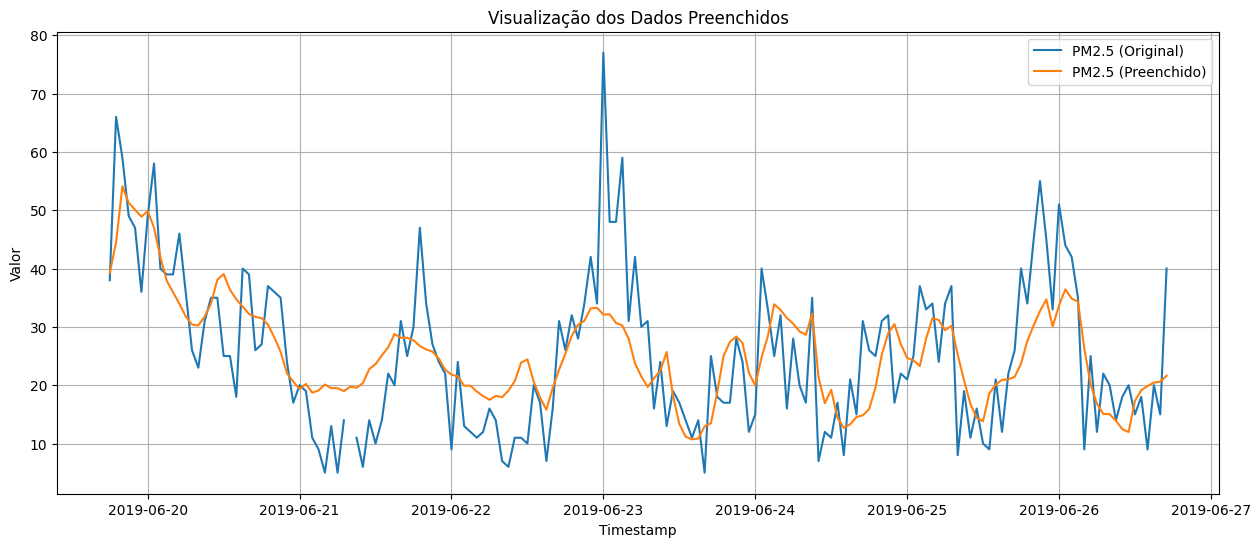

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(df['pm25'][4074:4242], label='PM2.5 (Original)')
plt.plot(df_preenchido['pm25'][4074:4242], label='PM2.5 (Preenchido)')
#plt.plot(df_preenchido['temp'], label='Temperatura (Preenchido)')
plt.title('Visualização dos Dados Preenchidos')
plt.xlabel('Timestamp')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()